In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.custom_head import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *

import wandb

In [3]:
#hide
wandb.init(name='MM-MNet-DS-1st',
           project='shot-framing',
           tags=['MobileNetV2', 'MixMatch', 'fastai', 'PyTorch'],
           entity='synopsis',
           reinit=True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/shot-framing/runs/mi9kqbrs

In [4]:
#hide
%env WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'

env: WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'


## Setup

In [5]:
path = Path('/home/rahul/github_projects/CinemaNet/')

In [6]:
config = wandb.config

config.img_size=to_film_ar(150)
config.batch_size=64
config.model='MobileNetV2'
config.mixup='True'
config.mixmatch='True'

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


In [7]:
il_train = ImageList.from_folder(path/'train', presort=True)
il_valid = ImageList.from_folder(path/'valid', presort=True)
regex = {
    'CU' : '\/Close\-Up\/',
    'ECU': '\/Extreme Close\-Up\/',
    'EWS': '\/Extreme Wide\/',
    'LS' : '\/Long\/',
    'MS' : '\/Medium\/',
    'MCU': '\/Medium Close\-Up\/'
}

In [8]:
len(il_train.items)
len(il_valid.items)

5505

600

In [9]:
fnames_all   = list(il_train.items) + list(il_valid.items)
count        = {}
train_fnames = {}
valid_fnames = {}
samples_per_label = 500


for key in regex:
    i=0
    train_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            train_fnames[key].append(f)
            if i >= samples_per_label: break; 
count

{'CU': 500, 'ECU': 500, 'EWS': 500, 'LS': 500, 'MS': 500, 'MCU': 500}

In [10]:
fnames_train = sum(train_fnames.values(),[])
fnames_valid = list(set(fnames_all) - set(fnames_train))

In [12]:
len(fnames_train), len(fnames_valid)

(3000, 3105)

In [13]:
def get_labels(f):
    if re.search(f"{regex['EWS']}", str(f)): return 'Extreme Wide'
    if re.search(f"{regex['LS']}",  str(f)): return 'Long'
    if re.search(f"{regex['MS']}",  str(f)): return 'Medium'
    if re.search(f"{regex['MCU']}", str(f)): return 'Medium Close-Up'
    if re.search(f"{regex['CU']}",  str(f)): return 'Close-Up'
    if re.search(f"{regex['ECU']}", str(f)): return 'Extreme Close-Up'

In [14]:
lls = LabelLists(path,
                 train=ImageList(fnames_train),
                 valid=ImageList(fnames_valid))

In [15]:
config.batch_size
config.img_size

64

[150, 266]

In [16]:
data = (lls
        .label_from_func(get_labels)
        .transform(tfms=get_transforms(max_zoom=1.),
                   size=config.img_size,
                   resize_method=ResizeMethod.SQUISH)
        .databunch(bs=config.batch_size).normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium Close-Up,Medium,Extreme Close-Up
Path: .;

Test: None

In [17]:
data.c

6

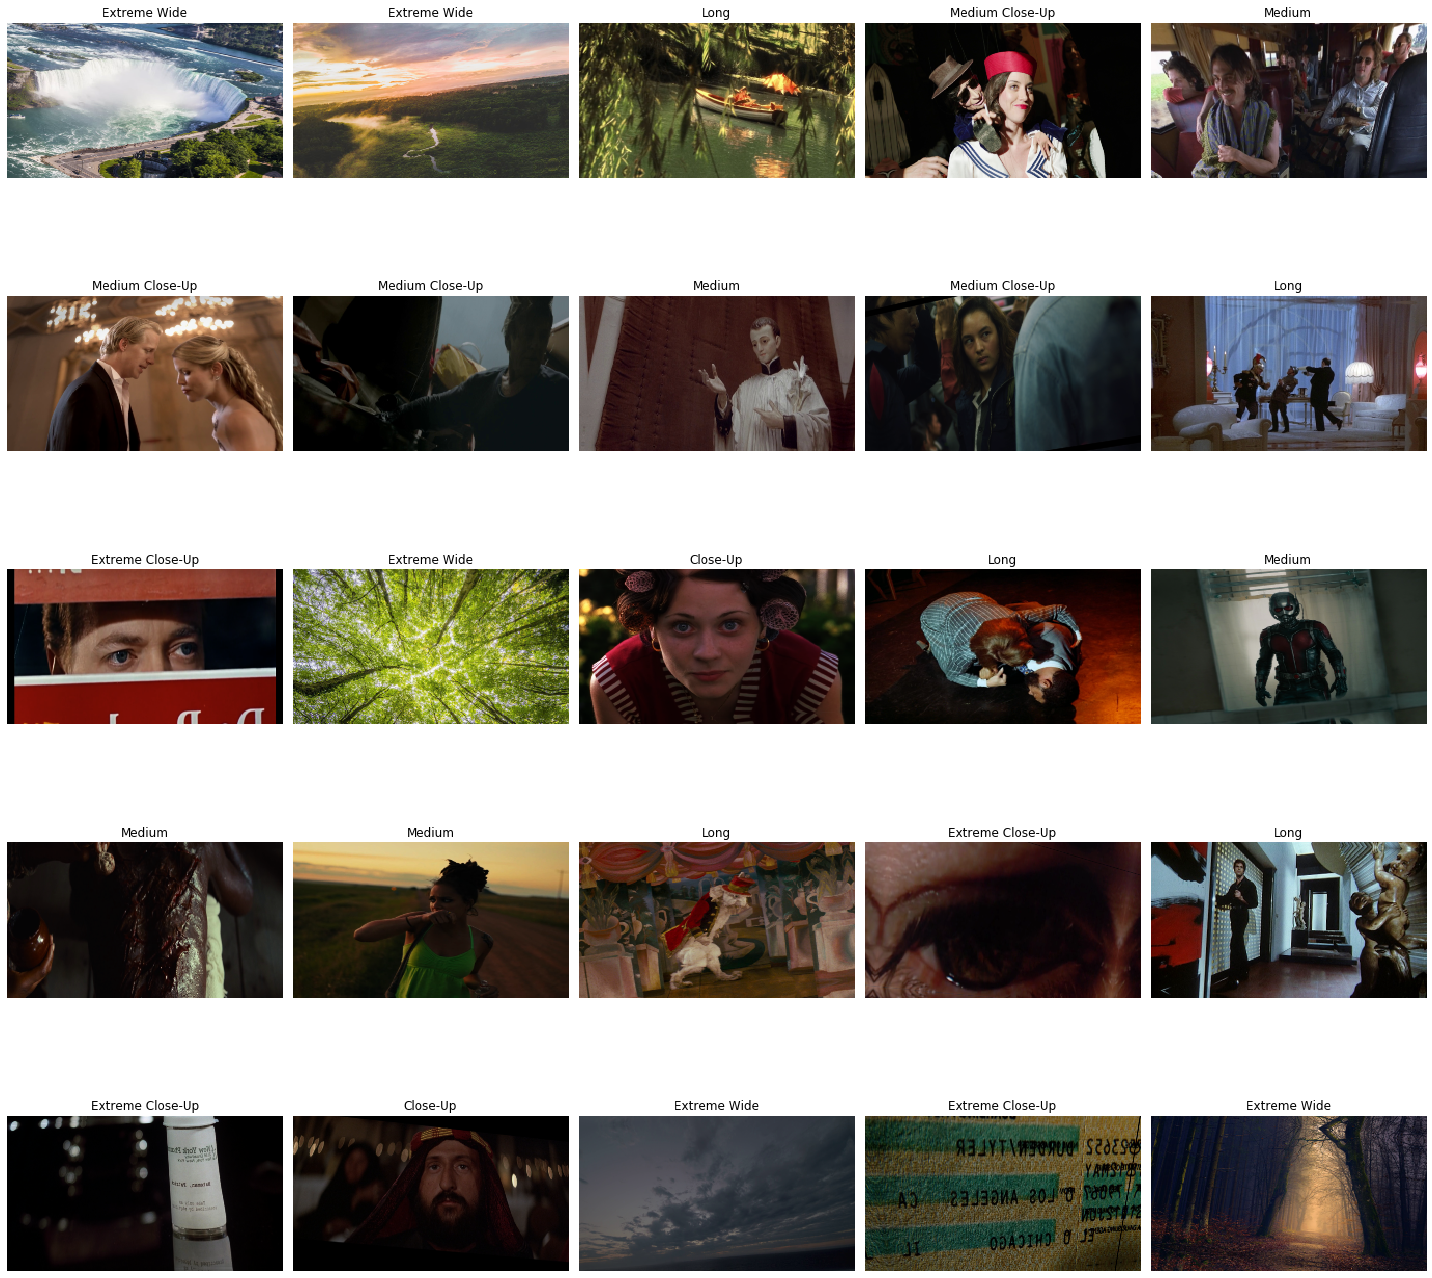

In [18]:
data.show_batch()

In [19]:
data_unlabelled = ImageList.from_folder(path/'filmgrab')
data_unlabelled

ImageList (95329 items)
Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024)
Path: /home/rahul/github_projects/CinemaNet/filmgrab

## MixMatch

In [20]:
arch = models.mobilenet_v2
learn = cnn_learner(data, arch, pretrained=True,
                    metrics=metrics).mixmatch(data_unlabelled, α=.75, λ=75, size=config.img_size)

In [21]:
learn.data

ImageDataBunch;

Train: MultiTfmLabelList (95329 items)
x: ImageList
[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)]
y: EmptyLabelList
,,,,
Path: /home/rahul/github_projects/CinemaNet/filmgrab;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium Close-Up,Medium,Extreme Close-Up
Path: .;

Test: None

labeled dataset     :         3,000 samples
unlabeled dataset   :        95,329 samples
total train samples :       285,888 samples


epoch,train_loss,valid_loss,accuracy,precision,recall,train_Lx,train_Lu*λ,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


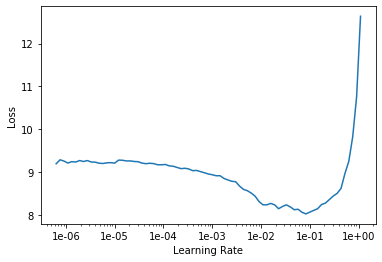

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='epoch', name=f'{mod_name}', monitor=monitor),
        #SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_val_loss', monitor='valid_loss'),
        #SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_accuracy', monitor='accuracy')
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [24]:
model_name = 'MobileNetV2-img_150-MixMatch-DS_run1'

# log every epoch -- sometimes, minor improvements in valid_loss/accuracy come with a massive
# drop in train_loss, which IMO is sub-optimal. It's better to pick up training from a point
# where both train and valid loss are not too low and then unfreeze and retrain
callbacks = get_callbacks(learn, model_name, patience=4, monitor='valid_loss')

In [25]:
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.267078,0.888417,0.749758,0.756233,0.780827,02:01
1,0.868334,0.714658,0.779710,0.792474,0.814649,01:59
2,0.634331,0.571018,0.809984,0.815106,0.832444,01:58
3,0.497562,0.589138,0.801610,0.843136,0.816860,01:57
4,0.371799,0.409032,0.851852,0.859088,0.873275,01:59
5,0.279661,0.364434,0.870209,0.869027,0.881444,01:57
6,0.222941,0.363334,0.872464,0.873029,0.883352,01:59


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with valid_loss value: 0.8884167075157166.
Better model found at epoch 1 with valid_loss value: 0.714658260345459.
Better model found at epoch 2 with valid_loss value: 0.5710176825523376.
Better model found at epoch 4 with valid_loss value: 0.4090317487716675.
Better model found at epoch 5 with valid_loss value: 0.36443355679512024.
Better model found at epoch 6 with valid_loss value: 0.3633338510990143.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200118_231130-mi9kqbrs/bestmodel.pth


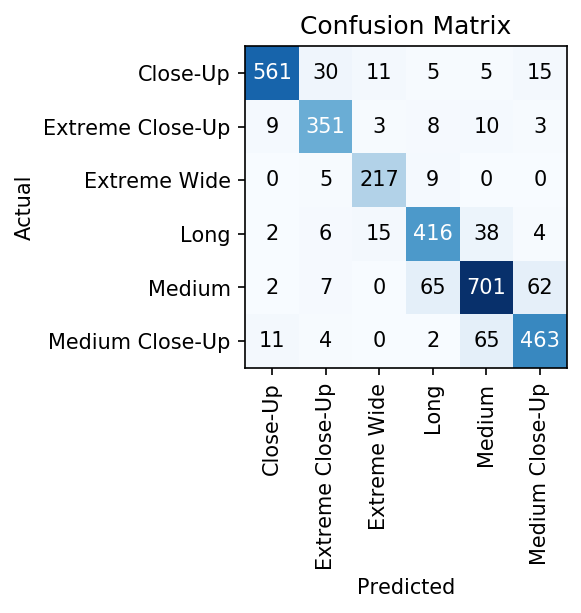

In [26]:
learn.fit_one_cycle(7, 5e-3, callbacks=callbacks)

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


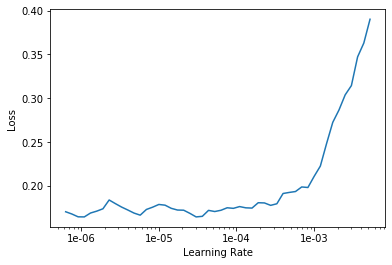

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
model_name = 'MobileNetV2-img_150-MixMatch-DS_run1-unfrozen'
callbacks = get_callbacks(learn, model_name, patience=4, monitor='accuracy')



epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.169740,0.364706,0.873108,0.872730,0.883768,02:10
1,0.159374,0.362421,0.873430,0.872265,0.885917,02:01
2,0.156821,0.351271,0.875684,0.874675,0.887504,02:06
3,0.160390,0.356172,0.874718,0.872504,0.886965,01:59
4,0.154818,0.361827,0.874396,0.872191,0.887281,02:00


Better model found at epoch 0 with accuracy value: 0.87310791015625.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 1 with accuracy value: 0.8734299540519714.
Better model found at epoch 2 with accuracy value: 0.875684380531311.
Epoch 5: early stopping
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200118_231130-mi9kqbrs/bestmodel.pth


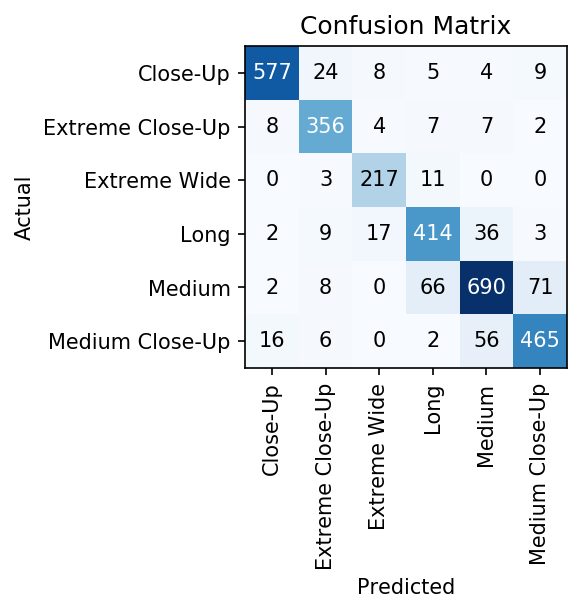

In [30]:
learn.fit_one_cycle(7, slice(1e-6, 1e-4), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.152904,0.350992,0.876651,0.874877,0.889178,02:02
1,0.144241,0.354771,0.876973,0.875716,0.889323,02:09
2,0.147612,0.374963,0.871498,0.869104,0.885154,02:02
3,0.148773,0.392843,0.868599,0.864902,0.883453,02:07
4,0.142221,0.412487,0.865056,0.864576,0.882847,02:01


Better model found at epoch 0 with accuracy value: 0.8766505718231201.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 1 with accuracy value: 0.8769726157188416.
Epoch 5: early stopping
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200118_231130-mi9kqbrs/bestmodel.pth


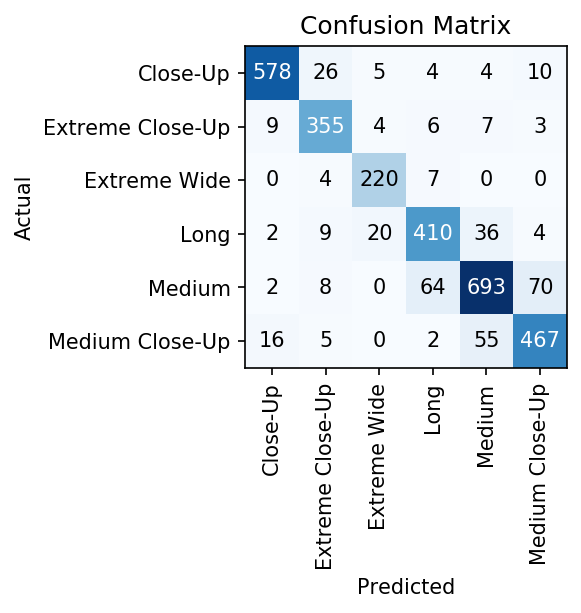

In [31]:
learn.fit_one_cycle(25, slice(1e-6,1e-3), callbacks=callbacks)

# 